In [190]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [184]:
myfile1 = open("/data1/bpnachman/DCTRFitting/output_part_172_5.txt")
myfile2 = open("/data1/bpnachman/DCTRFitting/output_part_175_0.txt")
myfiles = {}
myfiles[172.5] = myfile1
myfiles[175.0] = myfile2

mymJJs = {}
mymJJs_lep = {}

for myfile in myfiles:
    
    print(myfile)
    mymJJs[myfile] = []
    mymJJs_lep[myfile] = []

    mycounter = 0
    for line in myfiles[myfile]:
        mycounter+=1
        #if (mycounter > 100000):
        #    break
        if (mycounter%10000==0):
            print("   ",mycounter)
        #print(line.split())
        pTs = []
        etas = []
        phis = []
        ms = []
        PIDs = []

        lepton = []
        neutrino = []
        leptonbjet = []
        wjet1 = []
        wjet2 = []
        hadronicbjet = []

        for k in range(int(len(line.split())/6)):
            pT = float(line.split()[k*6+1])
            eta = float(line.split()[k*6+2])
            phi = float(line.split()[k*6+3])
            m = float(line.split()[k*6+4])
            PID = int(line.split()[k*6+5])

            pTs+=[pT]
            etas+=[eta]
            phis+=[phi]
            ms+=[m]
            if (k==1):
                PIDs+=[14]
                neutrino = [pT,eta,phi,m]
            elif (PID==13):
                PIDs+=[PID]
                lepton = [pT,eta,phi,m]
            else:
                PIDs+=[PID]
            pass

        #First, find the b-jet closest to the lepton.
        dRmin = 999.
        whichbjet = -1
        for k in range(len(pTs)):
            if (PIDs[k] != 1):
                continue
            #print(lepton[1],etas[k])
            dR = ((lepton[1]-etas[k])**2+(lepton[2]-phis[k])**2)*0.5
            if (dR < dRmin):
                dRmin = dR
                whichbjet = k
                pass
            pass

        #Now, let's take the other leading b jet as the second b jet.
        pTmax = -1
        whichbjet2 = -1
        for k in range(len(pTs)):
            if (PIDs[k] != 1):
                continue
            if (whichbjet==k):
                continue
            if (pTs[k] > pTmax):
                pTmax = pTs[k]
                whichbjet2 = k
                pass
            pass

        #Now, let's take the remaining jets and find the pair closest to the W mass.
        w1 = -1
        w2 = -1
        dmW = 999.
        for k in range(len(pTs)):
            if (PIDs[k] != 0):
                continue
            for k2 in range(len(pTs)):
                if (PIDs[k2] != 0):
                    continue

                px = (pTs[k]*np.cos(phis[k]) + pTs[k2]*np.cos(phis[k2]))
                py = (pTs[k]*np.sin(phis[k]) + pTs[k2]*np.sin(phis[k2]))
                pz = (pTs[k]*np.sinh(etas[k]) + pTs[k2]*np.sinh(etas[k2]))
                pE = (ms[k]**2 + (pTs[k]*np.cosh(etas[k]))**2)**0.5 + (ms[k2]**2 + (pTs[k2]*np.cosh(etas[k2]))**2)**0.5
                mJJ = (pE**2-px**2-py**2-pz**2)**0.5
                if (abs(mJJ - 80.4) < dmW):
                    dmW = abs(mJJ - 80.4)
                    w1 = k
                    w2 = k2
                    pass
                pass
            pass

        if (whichbjet < 0 or whichbjet2 < 0 or w1 < -1 or w2 < -1 or dRmin < 0.4):
            continue
        leptonbjet = [pTs[whichbjet],etas[whichbjet],phis[whichbjet],ms[whichbjet]]
        hadronicbjet = [pTs[whichbjet2],etas[whichbjet2],phis[whichbjet2],ms[whichbjet2]]
        wjet1 = [pTs[w1],etas[w1],phis[w1],ms[w1]]
        wjet2 = [pTs[w2],etas[w2],phis[w2],ms[w2]]

        '''
        print(PIDs)
        print("break")
        print(lepton)
        print(neutrino)
        print(leptonbjet)
        print(hadronicbjet)
        print(wjet1)
        print(wjet2)
        '''
        
        #solve for neutrino pz
        #mW^2 = 2(pl*pv - pzl*pzv - pTl*pTv)
        #     = 2(pl*sqrt(pTv^2 + pzv^2) - pzl*pzv - pxl*pxv - pyl*pyv)
        pl = lepton[0]*np.cosh(lepton[1])
        plz = lepton[0]*np.sinh(lepton[1])
        plx = lepton[0]*np.cos(lepton[2])
        ply = lepton[0]*np.sin(lepton[2])
        pvx = neutrino[0]*np.cos(neutrino[2])
        pvy = neutrino[0]*np.sin(neutrino[2])
        a = (plz**2-pl**2)
        b = (80.4**2+2.*(plx*pvx + ply*pvy))*plz
        c = (80.4**2/2. + plx*pvx + ply*pvy)**2 - pl**2*neutrino[0]**2
        pz = 0.
        if (b**2-4*a*c > 0):
            pz = (-b + (b**2-4*a*c)**0.5)/(2.*a)
            if (abs((-b - (b**2-4*a*c)**0.5)/(2.*a)) < pz):
                pz = (-b - (b**2-4*a*c)**0.5)/(2.*a)
                pass
            pass
        eta = np.arcsinh(pz/neutrino[0])
        neutrino[1] = eta
        pv = neutrino[0]*np.cosh(neutrino[1])
        pvz = neutrino[0]*np.sinh(neutrino[1])
        #print("check",np.sqrt(2.*(pl*pv - plz*pvz - plx*pvx - ply*pvy)))

        px = wjet1[0]*np.cos(wjet1[2]) + wjet2[0]*np.cos(wjet2[2])
        py = wjet1[0]*np.sin(wjet1[2]) + wjet2[0]*np.sin(wjet2[2])
        pz = wjet1[0]*np.sinh(wjet1[1]) + wjet2[0]*np.sinh(wjet2[1])
        pE = (wjet1[3]**2 + (wjet1[0]*np.cosh(wjet1[1]))**2)**0.5 + (wjet2[3]**2 + (wjet2[0]*np.cosh(wjet2[1]))**2)**0.5
        mW = (pE**2-px**2-py**2-pz**2)**0.5        
        
        px = (hadronicbjet[0]*np.cos(hadronicbjet[2]) + wjet1[0]*np.cos(wjet1[2]) + wjet2[0]*np.cos(wjet2[2]))
        py = (hadronicbjet[0]*np.sin(hadronicbjet[2]) + wjet1[0]*np.sin(wjet1[2]) + wjet2[0]*np.sin(wjet2[2]))
        pz = (hadronicbjet[0]*np.sinh(hadronicbjet[1]) + wjet1[0]*np.sinh(wjet1[1]) + wjet2[0]*np.sinh(wjet2[1]))
        pE = (hadronicbjet[3]**2 + (hadronicbjet[0]*np.cosh(hadronicbjet[1]))**2)**0.5 + (wjet1[3]**2 + (wjet1[0]*np.cosh(wjet1[1]))**2)**0.5 + (wjet2[3]**2 + (wjet2[0]*np.cosh(wjet2[1]))**2)**0.5                                                     
        mJJ = (pE**2-px**2-py**2-pz**2)**0.5 * 80.4/mW
        mymJJs[myfile]+=[mJJ]

        px = (leptonbjet[0]*np.cos(leptonbjet[2]) + lepton[0]*np.cos(lepton[2]) + neutrino[0]*np.cos(neutrino[2]))
        py = (leptonbjet[0]*np.sin(leptonbjet[2]) + lepton[0]*np.sin(lepton[2]) + neutrino[0]*np.sin(neutrino[2]))
        pz = (leptonbjet[0]*np.sinh(leptonbjet[1]) + lepton[0]*np.sinh(lepton[1]) + neutrino[0]*np.sinh(neutrino[1]))
        pE = (leptonbjet[3]**2 + (leptonbjet[0]*np.cosh(leptonbjet[1]))**2)**0.5 + (lepton[3]**2 + (lepton[0]*np.cosh(lepton[1]))**2)**0.5 + (neutrino[3]**2 + (neutrino[0]*np.cosh(neutrino[1]))**2)**0.5                                                     
        mJJ = (pE**2-px**2-py**2-pz**2)**0.5
        mymJJs_lep[myfile]+=[mJJ]
        
        #px = lepton[0]*np.cos(lepton[2]) + neutrino[0]*np.cos(neutrino[2])
        #py = lepton[0]*np.sin(lepton[2]) + neutrino[0]*np.sin(neutrino[2])
        #pz = lepton[0]*np.sinh(lepton[1]) + neutrino[0]*np.sinh(neutrino[1])
        #pE = lepton[0]*np.cosh(lepton[1]) + neutrino[0]*np.cosh(neutrino[1])               
        #mJJ = (pE**2-px**2-py**2-pz**2)**0.5
        #print("mW=",mJJ)
        #break

172.5


/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars


    10000
    20000
    30000
    40000
    50000
    60000
    70000
    80000
    90000
    100000
    110000
    120000
    130000
    140000
    150000
    160000
    170000
    180000
    190000
    200000
    210000
    220000
    230000
    240000
    250000
    260000
    270000
    280000
    290000
    300000
    310000
    320000
    330000
    340000
    350000
    360000
    370000
    380000
    390000
    400000
    410000
    420000
    430000
    440000
    450000
    460000
    470000
    480000
    490000
    500000
    510000
    520000
    530000
    540000
    550000
    560000
    570000
    580000
    590000
    600000
    610000
    620000
    630000
    640000
    650000
    660000
    670000
    680000
    690000
    700000
    710000
    720000
    730000
    740000
    750000
    760000
    770000
    780000
    790000
    800000
    810000
    820000
    830000
    840000
    850000
    860000
    870000
    880000
    890000
    900000
    910000
    9200

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars


    860000
    870000
    880000
    890000
    900000
    910000
    920000
    930000
    940000
    950000
    960000
    970000
    980000
    990000
    1000000


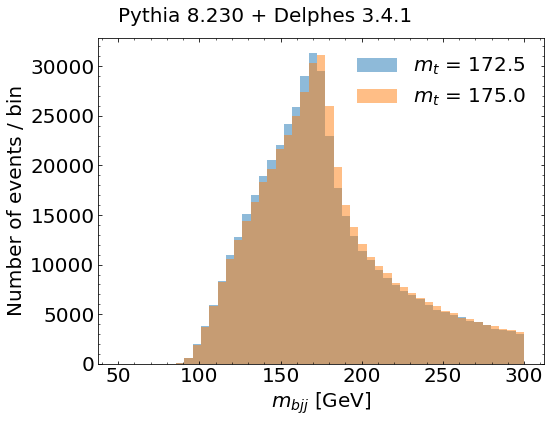

In [205]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()
    
n1,_,_=plt.hist(mymJJs[172.5],bins=np.linspace(50,300,50),alpha=0.5,label=r"$m_{t}$ = 172.5")
n2,_,_=plt.hist(mymJJs[175.0],bins=np.linspace(50,300,50),alpha=0.5,label=r"$m_{t}$ = 175.0")
plt.legend(frameon=False,fontsize=20)
plt.xlabel(r"$m_{bjj}$ [GeV]",fontsize=20)
plt.ylabel(r"Number of events / bin",fontsize=20)
plt.text(50,1.1*max(max(n1),max(n2)),"Pythia 8.230 + Delphes 3.4.1",fontsize=20)
fig.savefig("hadronictop.pdf")

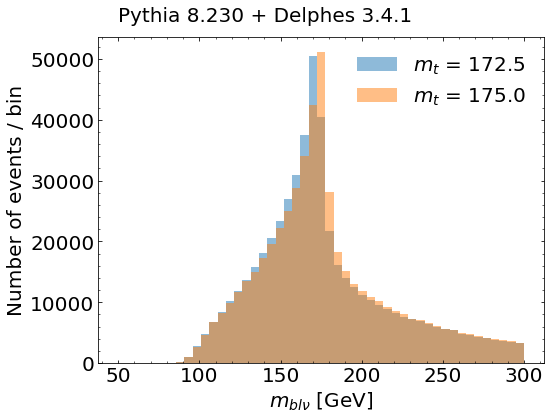

In [204]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

n1,_,_=plt.hist(mymJJs_lep[172.5],bins=np.linspace(50,300,50),alpha=0.5,label=r"$m_{t}$ = 172.5")
n2,_,_=plt.hist(mymJJs_lep[175.0],bins=np.linspace(50,300,50),alpha=0.5,label=r"$m_{t}$ = 175.0")
plt.legend(frameon=False,fontsize=20)
plt.xlabel(r"$m_{bl\nu}$ [GeV]",fontsize=20)
plt.ylabel(r"Number of events / bin",fontsize=20)
plt.text(50,1.1*max(max(n1),max(n2)),"Pythia 8.230 + Delphes 3.4.1",fontsize=20)
fig.savefig("leptonictop.pdf")

In [223]:
myfile = open("/data1/bpnachman/DCTRFitting/output_part_varmass.txt")

mymJJs_cont = []
mymJJs_lep_cont = []
topmass = []

mycounter = 0
for line in myfile:
    mycounter+=1
    #if (mycounter > 100000):
    #    break
    if (mycounter%10000==0):
        print("   ",mycounter)
    #print(line.split())
    pTs = []
    etas = []
    phis = []
    ms = []
    PIDs = []

    lepton = []
    neutrino = []
    leptonbjet = []
    wjet1 = []
    wjet2 = []
    hadronicbjet = []
    
    topmass+=[float(line.split()[6])]
    for k in range(int(len(line.split())/7)):
        pT = float(line.split()[k*7+1])
        eta = float(line.split()[k*7+2])
        phi = float(line.split()[k*7+3])
        m = float(line.split()[k*7+4])
        PID = int(line.split()[k*7+5])

        pTs+=[pT]
        etas+=[eta]
        phis+=[phi]
        ms+=[m]
        if (PID==14):
            PIDs+=[14]
            neutrino = [pT,eta,phi,m]
        elif (PID==13):
            PIDs+=[PID]
            lepton = [pT,eta,phi,m]
        else:
            PIDs+=[PID]
        pass

    #First, find the b-jet closest to the lepton.
    dRmin = 999.
    whichbjet = -1
    for k in range(len(pTs)):
        if (PIDs[k] != 1):
            continue
        #print(lepton[1],etas[k])
        dR = ((lepton[1]-etas[k])**2+(lepton[2]-phis[k])**2)*0.5
        if (dR < dRmin):
            dRmin = dR
            whichbjet = k
            pass
        pass

    #Now, let's take the other leading b jet as the second b jet.
    pTmax = -1
    whichbjet2 = -1
    for k in range(len(pTs)):
        if (PIDs[k] != 1):
            continue
        if (whichbjet==k):
            continue
        if (pTs[k] > pTmax):
            pTmax = pTs[k]
            whichbjet2 = k
            pass
        pass

    #Now, let's take the remaining jets and find the pair closest to the W mass.
    w1 = -1
    w2 = -1
    dmW = 999.
    for k in range(len(pTs)):
        if (PIDs[k] != 0):
            continue
        for k2 in range(len(pTs)):
            if (PIDs[k2] != 0):
                continue

            px = (pTs[k]*np.cos(phis[k]) + pTs[k2]*np.cos(phis[k2]))
            py = (pTs[k]*np.sin(phis[k]) + pTs[k2]*np.sin(phis[k2]))
            pz = (pTs[k]*np.sinh(etas[k]) + pTs[k2]*np.sinh(etas[k2]))
            pE = (ms[k]**2 + (pTs[k]*np.cosh(etas[k]))**2)**0.5 + (ms[k2]**2 + (pTs[k2]*np.cosh(etas[k2]))**2)**0.5
            mJJ = (pE**2-px**2-py**2-pz**2)**0.5
            if (abs(mJJ - 80.4) < dmW):
                dmW = abs(mJJ - 80.4)
                w1 = k
                w2 = k2
                pass
            pass
        pass

    if (whichbjet < 0 or whichbjet2 < 0 or w1 < -1 or w2 < -1 or dRmin < 0.4):
        continue
    leptonbjet = [pTs[whichbjet],etas[whichbjet],phis[whichbjet],ms[whichbjet]]
    hadronicbjet = [pTs[whichbjet2],etas[whichbjet2],phis[whichbjet2],ms[whichbjet2]]
    wjet1 = [pTs[w1],etas[w1],phis[w1],ms[w1]]
    wjet2 = [pTs[w2],etas[w2],phis[w2],ms[w2]]

    #solve for neutrino pz
    #mW^2 = 2(pl*pv - pzl*pzv - pTl*pTv)
    #     = 2(pl*sqrt(pTv^2 + pzv^2) - pzl*pzv - pxl*pxv - pyl*pyv)
    pl = lepton[0]*np.cosh(lepton[1])
    plz = lepton[0]*np.sinh(lepton[1])
    plx = lepton[0]*np.cos(lepton[2])
    ply = lepton[0]*np.sin(lepton[2])
    pvx = neutrino[0]*np.cos(neutrino[2])
    pvy = neutrino[0]*np.sin(neutrino[2])
    a = (plz**2-pl**2)
    b = (80.4**2+2.*(plx*pvx + ply*pvy))*plz
    c = (80.4**2/2. + plx*pvx + ply*pvy)**2 - pl**2*neutrino[0]**2
    pz = 0.
    if (b**2-4*a*c > 0):
        pz = (-b + (b**2-4*a*c)**0.5)/(2.*a)
        if (abs((-b - (b**2-4*a*c)**0.5)/(2.*a)) < pz):
            pz = (-b - (b**2-4*a*c)**0.5)/(2.*a)
            pass
        pass
    eta = np.arcsinh(pz/neutrino[0])
    neutrino[1] = eta
    pv = neutrino[0]*np.cosh(neutrino[1])
    pvz = neutrino[0]*np.sinh(neutrino[1])
    #print("check",np.sqrt(2.*(pl*pv - plz*pvz - plx*pvx - ply*pvy)))

    px = wjet1[0]*np.cos(wjet1[2]) + wjet2[0]*np.cos(wjet2[2])
    py = wjet1[0]*np.sin(wjet1[2]) + wjet2[0]*np.sin(wjet2[2])
    pz = wjet1[0]*np.sinh(wjet1[1]) + wjet2[0]*np.sinh(wjet2[1])
    pE = (wjet1[3]**2 + (wjet1[0]*np.cosh(wjet1[1]))**2)**0.5 + (wjet2[3]**2 + (wjet2[0]*np.cosh(wjet2[1]))**2)**0.5
    mW = (pE**2-px**2-py**2-pz**2)**0.5        

    px = (hadronicbjet[0]*np.cos(hadronicbjet[2]) + wjet1[0]*np.cos(wjet1[2]) + wjet2[0]*np.cos(wjet2[2]))
    py = (hadronicbjet[0]*np.sin(hadronicbjet[2]) + wjet1[0]*np.sin(wjet1[2]) + wjet2[0]*np.sin(wjet2[2]))
    pz = (hadronicbjet[0]*np.sinh(hadronicbjet[1]) + wjet1[0]*np.sinh(wjet1[1]) + wjet2[0]*np.sinh(wjet2[1]))
    pE = (hadronicbjet[3]**2 + (hadronicbjet[0]*np.cosh(hadronicbjet[1]))**2)**0.5 + (wjet1[3]**2 + (wjet1[0]*np.cosh(wjet1[1]))**2)**0.5 + (wjet2[3]**2 + (wjet2[0]*np.cosh(wjet2[1]))**2)**0.5                                                     
    mJJ = (pE**2-px**2-py**2-pz**2)**0.5 * 80.4/mW
    mymJJs_cont+=[mJJ]

    px = (leptonbjet[0]*np.cos(leptonbjet[2]) + lepton[0]*np.cos(lepton[2]) + neutrino[0]*np.cos(neutrino[2]))
    py = (leptonbjet[0]*np.sin(leptonbjet[2]) + lepton[0]*np.sin(lepton[2]) + neutrino[0]*np.sin(neutrino[2]))
    pz = (leptonbjet[0]*np.sinh(leptonbjet[1]) + lepton[0]*np.sinh(lepton[1]) + neutrino[0]*np.sinh(neutrino[1]))
    pE = (leptonbjet[3]**2 + (leptonbjet[0]*np.cosh(leptonbjet[1]))**2)**0.5 + (lepton[3]**2 + (lepton[0]*np.cosh(lepton[1]))**2)**0.5 + (neutrino[3]**2 + (neutrino[0]*np.cosh(neutrino[1]))**2)**0.5                                                     
    mJJ = (pE**2-px**2-py**2-pz**2)**0.5
    mymJJs_lep_cont+=[mJJ]

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in double_scalars


    10000
    20000
    30000
    40000
    50000
    60000
    70000
    80000
    90000
    100000
    110000
    120000
    130000
    140000
    150000
    160000
    170000
    180000
    190000
    200000
    210000
    220000
    230000
    240000
    250000
    260000
    270000
    280000
    290000
    300000
    310000
    320000
    330000
    340000
    350000
    360000
    370000
    380000
    390000
    400000
    410000
    420000
    430000
    440000
    450000
    460000
    470000
    480000
    490000
    500000
    510000
    520000
    530000
    540000
    550000
    560000
    570000
    580000
    590000
    600000
    610000
    620000
    630000
    640000
    650000
    660000
    670000
    680000
    690000
    700000
    710000
    720000
    730000
    740000
    750000
    760000
    770000
    780000
    790000
    800000
    810000
    820000
    830000
    840000
    850000
    860000
    870000
    880000
    890000
    900000
    910000
    9200

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in double_scalars


    3930000
    3940000
    3950000
    3960000
    3970000
    3980000
    3990000
    4000000
    4010000
    4020000
    4030000
    4040000
    4050000
    4060000
    4070000
    4080000
    4090000
    4100000
    4110000
    4120000
    4130000
    4140000
    4150000
    4160000
    4170000
    4180000
    4190000
    4200000
    4210000
    4220000
    4230000
    4240000
    4250000
    4260000
    4270000
    4280000
    4290000
    4300000
    4310000
    4320000
    4330000
    4340000
    4350000
    4360000
    4370000
    4380000
    4390000
    4400000
    4410000
    4420000
    4430000
    4440000
    4450000
    4460000
    4470000
    4480000
    4490000
    4500000
    4510000
    4520000
    4530000
    4540000
    4550000
    4560000
    4570000
    4580000
    4590000
    4600000
    4610000
    4620000
    4630000
    4640000
    4650000
    4660000
    4670000
    4680000
    4690000
    4700000
    4710000
    4720000
    4730000
    4740000
    4750000
    

Text(0, 0.5, 'Number of events')

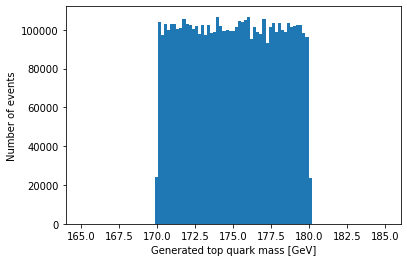

In [224]:
plt.hist(topmass,bins=np.linspace(165,185,100))
plt.xlabel("Generated top quark mass [GeV]")
plt.ylabel("Number of events")